## SLIM Pickins: An Interactive Circuit Layout Tool for Planar Traveling Wave Ion Guides
* BHC 01.Feb.2022
* [GNU General Public License v3.0](https://www.gnu.org/licenses/gpl-3.0.en.html)
* This research product was developed with the support of the [NIGMS](https://www.nigms.nih.gov/) R01-GM140129

### Objective: Simplify the layout of SLIM boards and facilitate rapid prototyping.  This script can aid in the export of exact SLIM monomer locations that can be imported into KiCad or another suitable PCB design tool. 

### How to use?

The general strategy is to layout a SLIM path similar to the path that a rudimentary game character might behave moving through a maze. A centipede character is a good example? 

![Path Track](https://1.bp.blogspot.com/-VgBXjKlVJds/XzB6hr2qfKI/AAAAAAAAZmI/XzzPcgEnl0Imw70Rn0xKA7ojnxBt7FHEQCLcBGAsYHQ/s384/centipede_path_size2.gif)

There are two key components to laying out a track. The starting direction decides which direction the paths are laid out and the track string details the absolute track path.  For example a starting direction of 'E' corresponds to an SLIM path with a starting direction of East for the ions. With this starting position and a path layout of "FRLF" would create a path that corresponds to a track that is ESEE (East, South, East, East). Using this strategy it is possible to layout the individual components of the SLIM board. It is recognized that multiple different types of SLIM paths may comprise a full board and this set of scripts allows for each section to be built independently.  

In addition to being a graphical tool, the center locations of each monomer are stored in a python dictionary that is exported to a json file.  This json file, when paired with a script for KiCad, can be used to explicitly layout the board. Be mindful that you understand that two different monomer footprints are needed in the PCB software. One with a guard above the tracks and one with the guard below the tracks. This is to ensure that guards do not conflict when turning different direction. 

<img src="BottomGuard.png" width=300 height=300 />
<img src="TopGuard.png" width=300 height=300 />
<!-- ![Bottom Guard](BottomGuard.png)
![Top Guard](TopGuard.png) -->

### Remember, above all, this is an *iterative* process.  The input parameters are the total length of a SLIM monomer and the relative centroid values following a turn. It is incumbent upon the user to move through the process in a deliberate manner and don't be afraid to revise previous track layouts to ensure they mesh. A final board review is always necessary.  Known conflicts with guard overlaps occur when different, indepdendent paths are overlaid upon each other to make a full board. 

<img src="TurnLayout.png" width=500 height=500 />

### Import Modules

In [1]:
# Key Imports
import numpy as np
import matplotlib.pyplot as plt
import json
%matplotlib inline

In [2]:

from IPython.display import display, HTML
from matplotlib.patches import Rectangle, Circle
%matplotlib inline

In [3]:
import matplotlib
from matplotlib import animation
matplotlib.rcParams['animation.embed_limit'] = 2**128 #needed for animation export

## Key SLIM Layout Variables

________

In [4]:
trackLen = 360 #width in mils
aOffset = 295.5 #turn offset A
bOffset = 64.5 #turn offset B

________

### Variables for Plotting

In [5]:
#Everthing below is related to plotting
trackMod = 25 #used for plotting to show the individual electrode footprints
guardOffset = trackLen/8*3 #used for plotting to simulate whether the guard should exist on the "top" or "bottom" relative to the electrodes
masterMS = 2 #marker size
upColor = '#2ca25f'#'r'
downColor = '#2c7fb8'#'b'
rightColor = '#de2d26'#'g'
leftColor = '#756bb1'#'#fecc5c'#k'

### Function to plot a single SLIM "Monomer"

In [6]:
def plotMonomer(mplAx, curX, curY, trackLen = trackLen, trackOffset = trackMod, guardOffset = guardOffset, showGuard = True, offsetBool = True, hBool = False, curColor = 'r', ms = 8, markerStyle = 'o', alphaLevelMain = 0.75, alphaLevelLo = 0.5, linewidth = 1.0):
    '''
    Requires:
        a matplotlib axis as an input
        X location
        Y location
        track length
        offset for plotting guard
        hBool is a boolean that determines whether the track is horizontal or vertical in nature
        Additoinal Plotting Parameters
    '''
    halfTrack = (trackLen/2)-trackOffset
    if hBool:
        if showGuard:
            if offsetBool:
                mplAx.hlines(curY+guardOffset, curX-halfTrack, curX+halfTrack, color = 'k', linestyle = ':', alpha = alphaLevelLo, linewidth = linewidth)
            else:
                mplAx.hlines(curY-guardOffset, curX-halfTrack, curX+halfTrack, color = 'k', linestyle = ':', alpha = alphaLevelLo, linewidth = linewidth)
        retLine = mplAx.hlines(curY, curX-halfTrack, curX+halfTrack, color = curColor, alpha = alphaLevelMain, linewidth = linewidth)
        mplAx.plot(curX, curY, markerStyle, color = curColor, mfc = 'w', markersize = ms, alpha = alphaLevelMain)
        return retLine
    else:
        if showGuard:
            if offsetBool:
                mplAx.vlines(curX+guardOffset, curY-halfTrack, curY+halfTrack, color = 'k', linestyle = ':', alpha = alphaLevelLo, linewidth = linewidth)
            else:
                mplAx.vlines(curX-guardOffset, curY-halfTrack, curY+halfTrack, color = 'k', linestyle = ':', alpha = alphaLevelLo, linewidth = linewidth)
        retLine = mplAx.vlines(curX, curY-halfTrack, curY+halfTrack, color = curColor, alpha = alphaLevelMain, linewidth = linewidth)
        mplAx.plot(curX, curY, markerStyle, color = curColor, mfc = 'w', markersize = ms, alpha = alphaLevelMain)
        return retLine
    

### Handle the directionality of the path and adjust the X,Y coordinates

In [7]:
def turnLogic(curLogic, nextLogic, curX, curY, aOffset = aOffset, bOffset = bOffset, trackLen = trackLen):
    '''
    When factoring in the current and next direction into account, determine the orientation of the current monomer. 
    '''
    if curLogic == 'N':
        if nextLogic == 'E': #right turn
            newX = curX + bOffset
            newY = curY + aOffset
        if nextLogic == 'W': #left turn
            newX = curX + -1*bOffset
            newY = curY + aOffset

    if curLogic == 'E':
        if nextLogic == 'S': #right turn
            newX = curX + aOffset
            newY = curY + -1*bOffset
        if nextLogic == 'N': #left turn
            newX = curX + aOffset
            newY = curY + bOffset            

    if curLogic == 'S':
        if nextLogic == 'E': #right turn
            newX = curX + bOffset
            newY = curY + -1*aOffset
        if nextLogic == 'W': #left turn
            newX = curX + -1*bOffset
            newY = curY + -1*aOffset                

    if curLogic == 'W':
        if nextLogic == 'N': #right turn
            newX = curX + -1*aOffset
            newY = curY + bOffset
        if nextLogic == 'S': #left turn
            newX = curX + -1*aOffset
            newY = curY + -1*bOffset 
            
    return newX, newY

### Movement Class for Each Monomer

In [8]:
'''
https://stackoverflow.com/questions/59108529/how-to-move-along-a-2d-grid-in-python
This class serves to navigate the path. Instead of a standard step of one, 
the class was modified to allow for the step size to move by the track length.
'''

class Point:
    def __init__(self, x: int, y:int , facing: str, stepMod = trackLen):
        self.x = x
        self.y = y
        self.stepMod = stepMod #BHC
        self.facing = facing
        self.lastFacing = facing

    def left(self):
        self.lastFacing = self.facing
        if self.facing == 'N':
            self.facing = 'W'
            self.x, self.y = turnLogic(self.lastFacing, self.facing, self.x, self.y)
            
        elif self.facing == 'W':
            self.facing = 'S'
            self.x, self.y = turnLogic(self.lastFacing, self.facing, self.x, self.y)
            
        elif self.facing == 'S':
            self.facing = 'E'
            self.x, self.y = turnLogic(self.lastFacing, self.facing, self.x, self.y)
            
        elif self.facing == 'E':
            self.facing = 'N'
            self.x, self.y = turnLogic(self.lastFacing, self.facing, self.x, self.y)            
            
        else:
            self.facing = 'N'

    def right(self):
        self.lastFacing = self.facing
        if self.facing == 'N':
            self.facing = 'E'
            self.x, self.y = turnLogic(self.lastFacing, self.facing, self.x, self.y)
            
        elif self.facing == 'E':
            self.facing = 'S'
            self.x, self.y = turnLogic(self.lastFacing, self.facing, self.x, self.y)
            
        elif self.facing == 'S':
            self.facing = 'W'
            self.x, self.y = turnLogic(self.lastFacing, self.facing, self.x, self.y)

        elif self.facing == 'W':
            self.facing = 'N'
            self.x, self.y = turnLogic(self.lastFacing, self.facing, self.x, self.y)
            
            
        else:
            self.facing = 'N'

    def forward(self):
        self.lastFacing = self.facing
        if self.facing == 'N':
            self.y += 1*self.stepMod
        elif self.facing == 'E':
            self.x += 1*self.stepMod
        elif self.facing == 'S':
            self.y -= 1*self.stepMod
        else:
            self.x -= 1*self.stepMod    

    def __repr__(self):
        return f"(x,y) = {(self.x,self.y)} \t{x} \t last direction = {self.lastFacing} \t direction = {self.facing} "

In [9]:
def colorLogic(curDirection, upColor = upColor, downColor = downColor, leftColor = leftColor, rightColor = rightColor):
    '''
    A default logic to determine the color you want for the different plotting. Default colors are specified above
    '''
    retColor = 'k'
    if curDirection == 'N':
        retColor = upColor
    if curDirection == 'S':
        retColor = downColor

    if curDirection == 'E':
        retColor = rightColor
    if curDirection == 'W':
        retColor = leftColor   
    
    return retColor

In [10]:
def createUPDOWN(numStraights = 10, reverseBool = False):
    '''
    Creates a series of up/down tracks. Used to speed the addition of serpentine path
    
    Assumes the prior direciton is "N"
    
    N* is the prior direcation
    
    This:
    
     E  S
    *N  S
        S
        S
        S
        S  N
        E  N
    
    Corresponds to this:
    
     R  R
    *F  F
        F
        F
        F
        F  F
        L  L
       
    
    '''
    

    dirStr = 'RR' #DOWN
    if reverseBool:
        dirStr = 'LL'
    
    
    dirStr += 'F'*numStraights
    
    
    if reverseBool:
        dirStr += 'RR' #UP
    else:
        dirStr += 'LL' #UP
    dirStr += 'F'*numStraights 
    
#     for n in range(numStraights):
#         dirStr+='F'
    
    return dirStr

In [11]:
def guardFlipLogic(lastDir, currentDir):
    '''
    This is for plotting only and determines where to put the guard. 
    The actual layout logic is in "footprintLogic"
    '''
    flipLogic = True
    if lastDir == 'W':
        if currentDir == 'N':
            flipLogic = False
        if currentDir == 'S':
            flipLogic = False
        if currentDir == 'W':
            flipLogic = False            
    if lastDir == 'S':
        if currentDir == 'W':
            flipLogic = False
        if currentDir == 'E':
            flipLogic = False
    return flipLogic

In [12]:
def footprintLogic(dirList, topTrackName = 'TW1GT{}', botTrackName = 'TW1GB{}'):
    '''
    Function to determine the name and orientation of the monomers in PCB layout.  The input parameters are the default
    used at WSU and correspond to the names of the footprints in KiCad. If you use this feature, adapt to the name
    of your specific library footprints. 
    '''
    nameList = []
    angleList = []
    lastD = dirList[0]
    
    topNameCore = topTrackName[:-2]#get rid of last {} characters
    botNameCore = botTrackName[:-2]#get rid of last {} characters
    
    topCount = 1
    botCount = 1
    #1st pass to setup locations and general directions
    for i,d in enumerate(dirList):
        
        if i == 0:#special case as we need to consider directions in pairs to decide the logic of the footpring
            curD = dirList[i]
            lastD = dirList[i]#get first direction
        else:
            lastD = curD
            curD = d
        
        if lastD == 'E':
            if curD == 'E':
                curName = topTrackName.format(topCount)
                topCount+=1
                curAngle = 0
            if curD == 'N':
                curName = botTrackName.format(botCount)
                botCount+=1
                curAngle = 90
            if curD == 'S':
                curName = topTrackName.format(topCount)
                topCount+=1
                curAngle = 270
        
        if lastD == 'N':
            if curD == 'N':
                prevName = nameList[-1]
                if topNameCore in prevName:
                    curName = topTrackName.format(topCount)
                    topCount+=1
                elif botNameCore in prevName:
                    curName = botTrackName.format(botCount)
                    botCount+=1
                curAngle = 90
            if curD == 'E':
                curName = topTrackName.format(topCount)
                topCount+=1
                curAngle = 0
            if curD == 'W':
                curName = botTrackName.format(botCount)
                botCount+=1
                curAngle = 180

        if lastD == 'W':
            if curD == 'W':
                curName = topTrackName.format(topCount)
                topCount+=1
                curAngle = 180
            if curD == 'N':
                curName = topTrackName.format(topCount)
                topCount+=1
                curAngle = 90
            if curD == 'S':
                curName = botTrackName.format(botCount)
                botCount+=1
                curAngle = 270 

        if lastD == 'S':
            if curD == 'S':
                prevName = nameList[-1]
                if topNameCore in prevName:
                    curName = topTrackName.format(topCount)
                    topCount+=1
                elif botNameCore in prevName:
                    curName = botTrackName.format(botCount)
                    botCount+=1                
                curAngle = 270
            if curD == 'E':
                curName = botTrackName.format(botCount)
                botCount+=1
                curAngle = 0              
            if curD == 'W':
                curName = topTrackName.format(topCount)
                topCount+=1
                curAngle = 180
        
    
        nameList.append(curName)
        angleList.append(curAngle)
        
    return nameList, angleList, topCount-1, botCount-1 #subtract one because each loop adds one at the end in anticipation for the enxt

In [13]:
#https://stackoverflow.com/questions/59108529/how-to-move-along-a-2d-grid-in-python

class Point:
    def __init__(self, x: int, y:int , facing: str, stepMod = trackLen):
        self.x = x
        self.y = y
        self.stepMod = stepMod #BHC
        self.facing = facing
        self.lastFacing = facing
        self.angle = 0

    def left(self):

        self.angle += 90
        self.angle = self.angle%360        
        
        self.lastFacing = self.facing
        if self.facing == 'N':
            self.facing = 'W'
            self.x, self.y = turnLogic(self.lastFacing, self.facing, self.x, self.y)
            
        elif self.facing == 'W':
            self.facing = 'S'
            self.x, self.y = turnLogic(self.lastFacing, self.facing, self.x, self.y)
            self.angle -= 90
            
        elif self.facing == 'S':
            self.facing = 'E'
            self.x, self.y = turnLogic(self.lastFacing, self.facing, self.x, self.y)
            
        elif self.facing == 'E':
            self.facing = 'N'
            self.x, self.y = turnLogic(self.lastFacing, self.facing, self.x, self.y)            
            
        else:
            self.facing = 'N'

    def right(self):

        self.angle -= 90
        self.angle = self.angle%360  
        
        self.lastFacing = self.facing
        if self.facing == 'N':
            self.facing = 'E'
            self.x, self.y = turnLogic(self.lastFacing, self.facing, self.x, self.y)
            
        elif self.facing == 'E':
            self.facing = 'S'
            self.x, self.y = turnLogic(self.lastFacing, self.facing, self.x, self.y)
            
        elif self.facing == 'S':
            self.facing = 'W'
            self.x, self.y = turnLogic(self.lastFacing, self.facing, self.x, self.y)

        elif self.facing == 'W':
            self.facing = 'N'
            self.x, self.y = turnLogic(self.lastFacing, self.facing, self.x, self.y)
            
            
        else:
            self.facing = 'N'

    def forward(self):
        self.lastFacing = self.facing
        if self.facing == 'N':
            self.y += 1*self.stepMod
        elif self.facing == 'E':
            self.x += 1*self.stepMod
        elif self.facing == 'S':
            self.y -= 1*self.stepMod
        else:
            self.x -= 1*self.stepMod    

    def __repr__(self):
        return f"(x,y) = {(self.x,self.y)} \t{x} \t last direction = {self.lastFacing} \t direction = {self.facing} "

In [14]:
def getLayoutParam(trackString, initDirection = 'E', curX = 0, curY = 0, sectionName = 'SLIM Track', markerStyle = 'o'):
    '''
    Link the core functions together to create a dictionary containin the necessary information for plotting
    and PCB layout. 
    '''
    
    startPos = initDirection
        
    #handle whether the line drawn should be horizontal or not
    hBool = True
    if startPos == 'N' or startPos == 'S':
        hBool = not hBool

    trackDict = {}        
    trackDict['origin'] = [curX, curY]
    
    
    curPoint = Point(curX,curY,startPos)
    xyPos = []
    boolList = []
    
    curAngleList = []

    curDirList = []
    for i,x in enumerate(trackString):
        if x == 'L':
            curPoint.left()
            hBool = not hBool
            boolList.append(hBool)
        elif x == 'R':
            curPoint.right()
            hBool = not hBool
            boolList.append(hBool)        
        else:
            curPoint.forward()
            boolList.append(hBool)

        xyPos.append([curPoint.x, curPoint.y])
        curDirList.append(curPoint.facing)

    #handle guards and their orientation
    guardFlipList = [True] #list of booleans, whether the guard is flipped or not depends upon the prior position
    currentDir = curDirList[0]
    for i,direction in enumerate(curDirList):
        if i == 0:
            currentDir = direction
        else:
            lastDir = currentDir
            currentDir = direction
            flipLogic = guardFlipLogic(lastDir, currentDir)
            guardFlipList.append(flipLogic)
    #         print(lastDir, currentDir)    
    
    trackDict['section name'] = sectionName
    trackDict['marker style'] = markerStyle
    trackDict['guard logic'] = guardFlipList
    trackDict['line bool'] = boolList
    trackDict['xy'] = xyPos
    trackDict['direction'] = curDirList


    return trackDict
    

In [15]:
def plotTrackSummary(trackDictList, plotBoardBool = False, boardDict = {}, boardColor = 'k', 
                     drillBool = False, drillDiameter = 125, drillColor = 'r', drillAlpha = 0.5, printDrill = False):
    '''
    Expects a list of dictionaries
    
    boardDict = {}
    boardDict['origin'] = (0,0)
    boardDict['x'] = 10
    boardDict['y'] = 20
    '''
    
    fig, ax = plt.subplots(figsize = (12,10))
    
    for trackDict in trackDictList:
        sectionName = trackDict['section name']
        guardFlipList = trackDict['guard logic']
        boolList = trackDict['line bool']
        xyPos = trackDict['xy']
        curDirList = trackDict['direction']
        curMarkerStyle = trackDict['marker style']
        if 'ms' in trackDict:
            curMS = trackDict['ms'] #marker size
        else:
            curMS = 8
        

        for i,xy in enumerate(xyPos):
            curX = xy[0]
            curY = xy[1]
            curBool = boolList[i]
            curColor = colorLogic(curDirList[i])
            guardLogic = guardFlipList[i]
            plotMonomer(ax, curX, curY, hBool = curBool, curColor = curColor, offsetBool = guardLogic, markerStyle = curMarkerStyle, ms = curMS)
    
    if plotBoardBool:
        if 'origin' in boardDict:
            boardOrigin = boardDict['origin'] #should be a tuple (e.g. (x,y) )
            #These values are swapped because things are rotated 270 so the origin is in the top left. 
            boardY = boardDict['x']
            boardX = boardDict['y']            
            ax.add_patch(Rectangle(boardOrigin,
                                   boardX, boardY,
                                   fc='none',
                                   color = boardColor,
                                   linewidth = 1,
                                   linestyle="-", angle = 270),)            
            
            if drillBool:
                drillOffsetX = boardDict['drill offset x']#
                drillOffsetY = boardDict['drill offset y']#                
                
                drillLocs = []
                xOrig = boardOrigin[0]
                yOrig = boardOrigin[1]
                
                pnt1X = xOrig+drillOffsetX
                pnt1Y = yOrig-drillOffsetY

                pnt2X = xOrig+drillOffsetX
                pnt2Y = yOrig-boardX+drillOffsetY                
                
                pnt3X = xOrig+boardY-drillOffsetX
                pnt3Y = yOrig-drillOffsetY

                pnt4X = xOrig+boardY-drillOffsetX
                pnt4Y = yOrig-boardX+drillOffsetY
                
                drillLocs.append([pnt1X, pnt1Y])
                drillLocs.append([pnt2X, pnt2Y])
                drillLocs.append([pnt3X, pnt3Y])
                drillLocs.append([pnt4X, pnt4Y])                
                
                for m,dl in enumerate(drillLocs):
                    dx = dl[0]
                    dy = dl[1]
                    
                    if printDrill:
                        print("Drill #%d: "%m, dx, dy)
                    curDrill = Circle((dx, dy), drillDiameter/2, color=drillColor, alpha = drillAlpha)
                    ax.add_patch(curDrill)
                
        
        else:
            print("Incorrect board information provided.")
            
    ax.set_aspect('equal', 'datalim')
    ax.margins(0.1)

In [16]:
def plotBackGroundTrack(ax, backGroundTrack, defaultMS = 0.01, colorLight = '#554f4e'):
    '''
    Used for animation to overlay two tracks. One for the total track and the other for the track you will animate.
    '''
    
    sectionNameBG = backGroundTrack['section name']
    guardFlipListBG = backGroundTrack['guard logic']
    boolListBG = backGroundTrack['line bool']
    xyPosBG = backGroundTrack['xy']
    curDirListBG = backGroundTrack['direction']
    curMarkerStyleBG = backGroundTrack['marker style']
    if 'ms' in backGroundTrack:
#         backGroundTrack['ms'] = defaultMS
        curMSBG = backGroundTrack['ms'] #marker size
    else:
        curMSBG = defaultMS


    lineList = []

    for j,ab in enumerate(xyPosBG):
        curA = ab[0]
        curB = ab[1]
        curBoolX = boolListBG[j]
        guardLogicX = guardFlipListBG[j]
        slimLine = plotMonomer(ax, curA, curB, hBool = curBoolX, curColor = colorLight, 
                              showGuard = False, offsetBool = guardLogicX, markerStyle = curMarkerStyle, 
                              ms = curMSBG, alphaLevelLo = 0.15, alphaLevelMain = 0.25)  
        lineList.append(slimLine)

    return lineList

In [17]:
def animateRange(trackDict, animLen, backGroundTrack = None, colorLight = '#554f4e', colorDark = '#990000', 
                 defaultMS = 0.1, figsize = (12,10), interval = 50, numIters = -1):
    
    '''
    Accepts a dictionary from getLayoutParam
    Input parameters takes a length of track to be animated. 
    
    There are multiple nested functions. This is not ideal but matplotlib animation is funky. 
    Especially, if you want to overlay paths. 
    
    '''
    
    #Setup Main Plot
    fig, ax = plt.subplots(figsize = figsize)
    
    #Setup Animated Path
    xyPos = trackDict['xy']
    
    ###
    indMin = 0 
    indMax = 0
    indLen = animLen #length of the ion train
    maxVal = len(xyPos)
    
    if indLen>maxVal:
        print("The requested length to animate is too long. It must be less than the total path")
        return False
    
    maxBool = False
    ###
    
    if numIters < 0:
        numIters = len(xyPos)+indLen
    
#     setup background path
    if backGroundTrack == None:
        backGroundTrack = trackDict
        
    lineList = plotBackGroundTrack(ax, trackDict, defaultMS = defaultMS, colorLight = colorLight)        
    lineListBG = plotBackGroundTrack(ax, backGroundTrack, defaultMS = defaultMS, colorLight = colorLight)


    def init():
        lineList = plotBackGroundTrack(ax, trackDict, defaultMS = defaultMS, colorLight = colorLight)
        lineListBG = plotBackGroundTrack(ax, backGroundTrack, defaultMS = defaultMS, colorLight = colorLight)

        return lineList

    def handleMinMax(i, indLen = indLen, maxVal = maxVal):
        curMin = 0
        curMax = i
        if i < indLen:
            curMin = 0
        else:
            curMin = i-indLen

        if curMax>maxVal:
            curMax = maxVal

        return curMin, curMax
    # animation function.  This is called sequentially
    def animate(i):

        curMin, curMax = handleMinMax(i)

        for ll in lineList:
            ll.set_alpha(0.25)
            ll.set_color(colorLight)
            ll.set_linewidth(1)


        for ll in lineList[curMin:curMax]:
            ll.set_alpha(1)
            ll.set_color(colorDark)
            ll.set_linewidth(3)

        return lineList

    ax.set_aspect('equal', 'datalim')
    plt.grid()
    plt.axis('off')
    
    anim = animation.FuncAnimation(fig, animate, frames= numIters, interval=interval) #maxVal+indLen
    
    return anim

In [18]:
def combineTracks(trackList, mergedName = 'Merged Tracks'):
    '''
    Accepts a list of track dictionaries and merges them together.  This may prove useful for both 
    plotting and export of the json for PCB layout. 
    '''
    if type(trackList) != list:
        print("A list of track dictionaries is required. You did not supply a list")
        return 0

    newTrackDict = {}
    newTrackDict['section name'] = mergedName
    newTrackDict['guard logic'] = []
    newTrackDict['line bool'] = []
    newTrackDict['xy'] = []
    newTrackDict['direction'] = []
    newTrackDict['marker style'] = trackList[0]['marker style']    
    
    for trackDict in trackList:
        newTrackDict['guard logic'] += trackDict['guard logic']
        newTrackDict['line bool'] += trackDict['line bool']
        newTrackDict['xy'] += trackDict['xy']
        newTrackDict['direction'] += trackDict['direction']
        newTrackDict['marker style'] = trackDict['marker style']

    return newTrackDict

In [19]:
def calcSLIMLengthParams(mainTrack, crimpTrack):
    '''
    Highly simplified calculation of SLIM track length
    Total lengths are slightly off due to the fact that turns are not scaled. 
    '''
    xyMain = mainTrack['xy']
    xyCrimp = crimpTrack['xy']
    plInches = 0.360*(len(xyMain)+len(xyCrimp))

    mainInches = 0.360*(len(xyMain))
    mainL = mainInches*2.54

    crimpInches = 0.360*(len(xyCrimp))
    crimpL = crimpInches*2.54

    pl = plInches*2.54

    #values in meters
    print("Main Track Length: %.2f m"%(mainL/100))
    print("CRIMP Track Length: %.2f m"%(crimpL/100))
    print("Total Path Length: %.2f m"%(pl/100))
    print("Ratio of SLIM to CRIMP Paths: %.2f"%(mainL/crimpL))
    print("%% of length for SLIM: %.2f "%(mainL/pl*100))
    print("Note: These lengths are geometric lengths and NOT scaled for turns\nAdditionally, the total length also includes the contribution from the entrance.")
#     print(mainL/100, crimpL/100, pl/100, mainL/pl*100)    

### JSON Serialization/Deserialization Script

In [20]:
def dumpJSON(outputName, dataDict):
    # Serialization to disk
    with open(outputName, "w") as write_file:
        json.dump(dataDict, write_file)
        print("Done Writing %s to disk"%outputName)
    
def restoreJSON(inputName):
    # Deserialization from disk
    with open(inputName, "r") as read_file:
        dataDict = json.load(read_file)    
        print("Dont reading %s from disk"%inputName)
        return dataDict

In [21]:
def cleanSLIMDict(trackDict, boardInfo = 'Test Layout', topTrackName = 'TW1GT{}', botTrackName = 'TW1GB{}'):
    '''
    
    Wraps the footprintLogic function and cleans up the SLIM dictionary for export to json. This must also
    be run through the flipPCBDict which exports a flattened and simplified dictionary that can be used for export.
    
    Assumed Dictionaries:
    
    'xy'
    'direction'
    'origin'
    
    For the SLIM there are a minimum of two types of tracks.  One with the guard on top and one on the bottom. 
    We need to classify the different tracks setup in the script as top/bottom. 
    
    IDEALLY, your footprint names in python will match those in KiCad. 
    
    '''
    
    reqKeys = ['xy', 'direction', 'origin']
    for rq in reqKeys:
        if rq not in trackDict:
            print("%s, not in dictionary. It is required!"%rq)
            return False
    
    xyList = trackDict['xy']
    dirList = trackDict['direction']
    origin = trackDict['origin']

    nameList, angleList, topCount, botCount = footprintLogic(dirList)

    pcbDict = {}
    pcbDict['boardParams'] = boardInfo
    pcbDict['name'] = nameList
    pcbDict['xy'] = xyList
    pcbDict['angle'] = angleList
    pcbDict['origin'] = origin

    print("Type and Number of Footprings Needed BEFORE running script in KiCad (* is the footprint number):")
    print('\t', topTrackName.format('*'), ': ', topCount)
    print('\t', botTrackName.format('*'), ': ', botCount)    
    
    return pcbDict
    

In [22]:
def flipPCBDict(pcbDict):
    '''
    Accepts a cleaned dictionary. 
    The new dictionary is the only one that should be exported to json. 
    '''
    newDict = {}
    fpNames = pcbDict['name']
    xyPos = pcbDict['xy']
    angles = pcbDict['angle']
    for i,fpn in enumerate(fpNames):
        newDict[fpn] = [xyPos[i], angles[i]]
    newDict['origin'] = pcbDict['origin']
    return newDict

## Begin of SLIM Layout Section

### Main Track Layout

In [23]:
letterHeight = 3
W = 'FFR'
W += 'F'*(letterHeight)
W += 'L' 
W += 'F'*(int(letterHeight/2))
W += 'L'
W += 'F'*(letterHeight)
W += 'RR'
W += 'F'*(letterHeight)
W += 'L' 
W += 'F'*(int(letterHeight/2))
W += 'L'
W += 'F'*(letterHeight)
W += 'RR'
W += 'F'*(letterHeight)
W += 'L'

In [24]:
S = 'FF'
S += 'F'*(letterHeight)
S += 'L'
S += 'F'*(int(letterHeight/2))
S += 'L'
S += 'F'*(letterHeight)
S += 'R'
S += 'F'*(int(letterHeight/2))
S += 'R'
S += 'F'*(letterHeight)

In [25]:
U = 'FFR'
U += 'F'*(letterHeight)
U += 'L' 
U += 'F'*(int(letterHeight))
U += 'L'
U += 'F'*(letterHeight)
U += 'R'
U += 'F'
# U += 'RR'
# U += 'F'*(letterHeight)
# U += 'L' 
# U += 'F'

In [26]:
trackString = W+S+U#W
   

print(trackString)

FFRFFFLFLFFFRRFFFLFLFFFRRFFFLFFFFFLFLFFFRFRFFFFFRFFFLFFFLFFFRF


### Evaluate the individual parameters returned. 

In [27]:
trackDictMain = getLayoutParam(trackString, 'E')

sectionName = trackDictMain['section name']
guardFlipList = trackDictMain['guard logic']
boolList = trackDictMain['line bool']
xyPos = trackDictMain['xy']
curDirList = trackDictMain['direction']
curMarkerStyle = trackDictMain['marker style']

#### Board Information Dictionary
* Include drill locations if you need them.
* These only relate to the corners. 

In [28]:
boardDict = {}
boardDict['origin'] = (180,910)
boardDict['x'] = 7920
boardDict['y'] = 3000
drillOffsetX = 15
drillOffsetY = 5
boardDict['drill offset x'] = (drillOffsetX/25.4)*1000 #this is 15 mm
boardDict['drill offset y'] = (drillOffsetY/25.4)*1000 #this is 5 mm

In [29]:
# def plotTrackSummary(trackDictList, plotBoardBool = False, boardDict = {}, boardColor = 'k', 
#                      drillBool = False, drillDiameter = 125, drillColor = 'r', drillAlpha = 0.5):

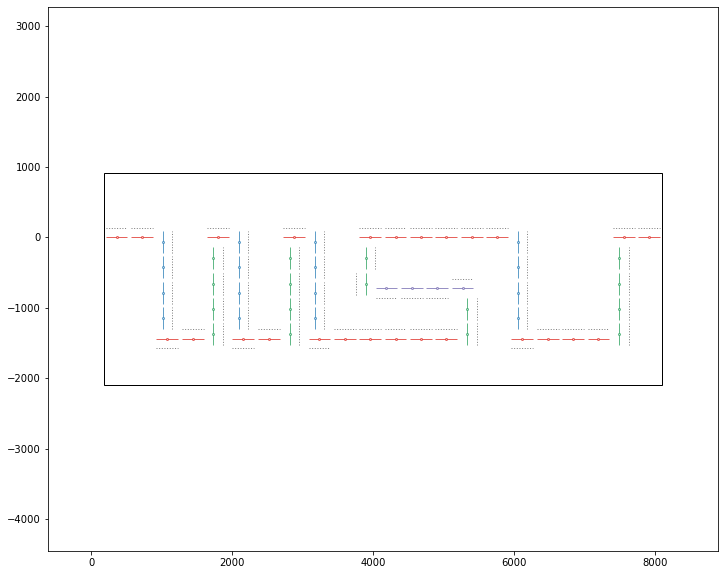

In [30]:
trackDictMain['ms'] = masterMS
plotTrackSummary([trackDictMain], plotBoardBool=True, boardDict=boardDict, drillBool = False, printDrill = True, drillAlpha = 0.75)

In [31]:
trackDictMain['xy'][-1]

[7920.0, 0.0]

In [32]:
pcbDictMain = cleanSLIMDict(trackDictMain, boardInfo = 'Main SLIM')

Type and Number of Footprings Needed BEFORE running script in KiCad (* is the footprint number):
	 TW1GT* :  43
	 TW1GB* :  19


In [33]:
sortedPCBDictMain = flipPCBDict(pcbDictMain)

In [34]:
outputName = 'WSULayoutMain.json'
dumpJSON(outputName, sortedPCBDictMain)

Done Writing WSULayoutMain.json to disk


## Note: Depending on the size of the tracks, the time for animation can be considerable.  Go get a cup of coffee.  Also, if you need mp4, you need to install ffmpeg.  This can be a pain as the paths need to specified properly on your system. 

In [35]:
# animateRange(trackDict, animLen, backGroundTrack = None, colorLight = '#554f4e', colorDark = '#990000', 
#                  defaultMS = 0.1, figsize = (12,10), interval = 50, numIters = -1):

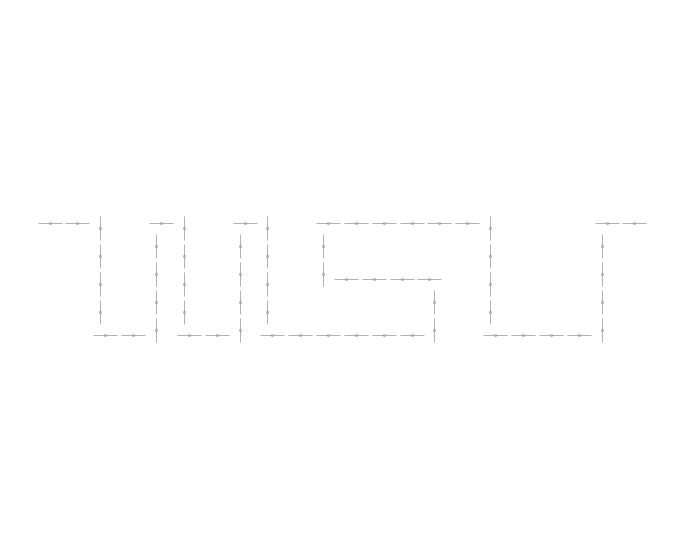

In [36]:
anim = animateRange(trackDictMain, 5, backGroundTrack = None, numIters = -1, interval = 50)

In [37]:
HTML(anim.to_jshtml())

In [38]:
plt.rcParams['animation.ffmpeg_path'] = '/opt/homebrew/bin/ffmpeg'

In [39]:
mywriter = animation.FFMpegWriter(fps = 30)

In [40]:
anim.save('WSU.mp4', writer=mywriter)

In [42]:
anim.save('WSU.gif', writer='imagemagick', savefig_kwargs={'transparent': False, 'facecolor': 'white'})